In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd 
import numpy as np
import h5py
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import math
import matplotlib.pyplot as plt

In [2]:
##wt files 
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33',
 'GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18',
 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34']

ko_sessions = ['GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 'GRIN018_H17_M41_S43',
 'GRIN018_H16_M13_S53', 'GRIN011_H10_M19_S59', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 'GRIN012_H16_M57_S23']

In [3]:
#need to get keys first from all session dataframes to read into pandas 
h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/event_analysis/mm_tracking_output/movement_regions_for_analysis.h5')
keys=h5file.keys()
h5file.close()

In [4]:
#keys

In [5]:
#load fluorescence in event regions
z_scored_events_by_session = {key_idx.strip('/'):pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/mm_tracking_output/movement_regions_for_analysis.h5', key=key_idx) for key_idx in keys}

In [6]:
#z_scored_events_by_session['GRIN038_H11_M57_S0']

In [7]:
#load velocity data 
#load speed trace -- should be able to align this using a time delta index
velocity_data = {}
for session in z_scored_events_by_session.keys(): 
    speed_trace = pd.read_csv('/projects/b1118/miniscope/analysis/compiled_data/mm_tracking_output/'+session+'_speedtrace.csv',names=['mm_speed'])
    speed_trace_td = speed_trace.set_index(pd.to_timedelta(np.linspace(0, (len(speed_trace)-1)*(.2), len(speed_trace)), unit='s'))
    speed_trace_td['datetime']=speed_trace_td.index.values.astype('datetime64[ns]')
    velocity_data[session] = speed_trace_td
velocity_data = pd.concat(velocity_data, keys=velocity_data.keys())

In [8]:
#bin velocity 
velocity_data['velocity_bins']= pd.cut(velocity_data['mm_speed'], bins=25)

In [9]:
def concat_by_mouse(df_unsorted):
    sorted_by_mouse = {mouse:[] for mouse in list(set([session[0:7] for session in list(df_unsorted.columns.levels[0])]))}
    for mouse in sorted_by_mouse.keys():
        for session in list(df_unsorted.columns):
            if session[0:7] == mouse:
                sorted_by_mouse[mouse].append(df_unsorted[session])
    concat_by_mouse_df = pd.DataFrame({mouse:pd.concat(sorted_by_mouse[mouse], axis=1).mean(axis=1) for mouse in list(sorted_by_mouse.keys())})
    return(concat_by_mouse_df)

In [10]:
#helper functions for calculating event probability during movement periods 
def return_list_of_start_indicies_in_session(event_regions_in_session_df):
    indicies = list(set([event_regions_in_session_df.index[idx][0] for idx in range(len(event_regions_in_session_df.index))]))
    indicies.sort()
    return(indicies)
def return_list_of_stop_indicies_in_session(event_regions_in_session_df):
    indicies = list(set([event_regions_in_session_df.index[idx][1] for idx in range(len(event_regions_in_session_df.index))]))
    indicies.sort()
    return(indicies)
def group_events_by_max_v_bin(velocity_by_session, start_indicies_in, stop_indicies_in):
    max_v_bins_in_session = {}
    for st_idx, end_idx in zip(start_indicies_in, stop_indicies_in):
        max_v_bins_in_session[st_idx]=velocity_by_session.loc[st_idx:end_idx]['velocity_bins'].max()
    return(max_v_bins_in_session)
def group_events_by_unique_bin(unique_bins, all_events_by_bin):
    sorted_by_v_bin={}
    for v_bin in unique_bins:
        events_with_v_bin=[]
        for event in list(all_events_by_bin.keys()):
            if all_events_by_bin[event]==v_bin:
                events_with_v_bin.append(event)
        sorted_by_v_bin[v_bin.left]=events_with_v_bin
    return(sorted_by_v_bin)

In [11]:
z_scored_events_by_session.keys()

dict_keys(['GRIN009_H13_M59_S14', 'GRIN011_H10_M19_S59', 'GRIN012_H16_M57_S23', 'GRIN012_H17_M32_S17', 'GRIN013_H13_M33_S54', 'GRIN018_H16_M13_S53', 'GRIN018_H17_M41_S43', 'GRIN027_H13_M29_S44', 'GRIN032_H17_M30_S22', 'GRIN033_H13_M42_S33', 'GRIN033_H14_M34_S32', 'GRIN034_H15_M28_S2', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18', 'GRIN035_H13_M31_S20', 'GRIN035_H13_M50_S58', 'GRIN035_H14_M40_S34', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN038_H15_M39_S40', 'GRIN039_H12_M26_S54', 'GRIN039_H12_M33_S29', 'GRIN039_H14_M8_S53', 'GRIN041_H12_M54_S49'])

In [12]:
#z_scored_events_by_session['GRIN039_H12_M26_S54'].loc['z_scored_movement_regions']

In [20]:
velocity_data_resampled = velocity_data
##loop over all sessions and extract event probability, binned by velocity 
##event theshold
event_threshold = 4
#for now "rest bin" is 0 ( or np.NINF, negative infinity ? )
event_p_by_session={}
events_by_session_sorted_by_unique_bin = {}
for session in list(z_scored_events_by_session.keys()):
    #print(session)
    start_indicies = return_list_of_start_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'])
    end_indicies = return_list_of_stop_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'])

    max_v_bins_in_session = group_events_by_max_v_bin(velocity_data_resampled.loc[session], start_indicies, end_indicies)

    unique_max_v_bins_in_session = list(set(list(max_v_bins_in_session.values())))

    sorted_by_unique_bin = group_events_by_unique_bin(unique_max_v_bins_in_session, max_v_bins_in_session)

    event_p_by_vbin={}
    for v_bin in list(sorted_by_unique_bin.keys()):
        event_p_by_vbin[v_bin] = utils_jjm.calculate_event_probability(z_scored_events_by_session[session].loc['z_scored_rest_regions'], 
                                                                   z_scored_events_by_session[session].loc['z_scored_movement_regions'].loc[sorted_by_unique_bin[v_bin]], event_threshold)[0]
        event_p_by_vbin[0] = utils_jjm.calculate_event_probability(z_scored_events_by_session[session].loc['z_scored_rest_regions'], 
                                                                    z_scored_events_by_session[session].loc['z_scored_movement_regions'].loc[sorted_by_unique_bin[v_bin]], event_threshold)[1]
    event_p_by_session[session]=pd.concat(event_p_by_vbin, keys=list(event_p_by_vbin.keys())).droplevel(1)
    events_by_session_sorted_by_unique_bin[session] = sorted_by_unique_bin

In [21]:
# should remove velocity bins greater than 10 (or 1 cm/sec) (likely reflects noise in tail base detection)
# for mm tracking remove greater than 20 cm/sec
for session in list(event_p_by_session.keys()):
    event_p_by_session[session].drop([i for i in event_p_by_session[session].index if i>20], inplace=True)   

In [22]:
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 
               'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33', 'GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 
               'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18', 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 
               'GRIN035_H14_M40_S34']

ko_sessions = ['GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 
               'GRIN018_H17_M41_S43', 'GRIN018_H16_M13_S53', 'GRIN011_H10_M19_S59', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 
               'GRIN012_H16_M57_S23']

In [23]:
# group by wt and ko
wt_event_by_session = {k:v for k,v in zip(event_p_by_session.keys(), event_p_by_session.values()) if k in wt_sessions}
wt_event_by_session_df = pd.concat(wt_event_by_session.values(),keys=wt_event_by_session.keys(), axis=1)
ko_event_by_session = {k:v for k,v in zip(event_p_by_session.keys(), event_p_by_session.values()) if k in ko_sessions}
ko_event_by_session_df = pd.concat(ko_event_by_session.values(),keys=ko_event_by_session.keys(), axis=1)

In [24]:
#normalize to resting values
norm_to_rest_wt = wt_event_by_session_df/wt_event_by_session_df.loc[0]
norm_to_rest_ko = ko_event_by_session_df/ko_event_by_session_df.loc[0]
#change infinity values to nan so mean function ignores them 
norm_to_rest_wt_no_inf = norm_to_rest_wt.replace([np.inf, -np.inf], np.nan)
norm_to_rest_ko_no_inf = norm_to_rest_ko.replace([np.inf, -np.inf], np.nan)

In [25]:
#sorted_by_mouse = {mouse:[] for mouse in list(set([session[0:7] for session in list(wt_event_by_session_df.columns.levels[0])]))}

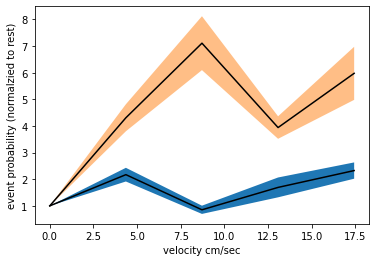

In [26]:
## wt versus ko plot, norm to rest, across cells
pixel_scale = 1
#x_scaled = norm_to_rest_wt_no_inf.mean(axis=1).index

fig = plt.figure()
plt.plot(list(norm_to_rest_wt_no_inf.mean(axis=1).index), norm_to_rest_wt_no_inf.mean(axis=1), color='k')

std_error = norm_to_rest_wt_no_inf.std(axis=1)/math.sqrt(len(list(norm_to_rest_wt_no_inf.columns)))

plt.fill_between(list(norm_to_rest_wt_no_inf.mean(axis=1).index), norm_to_rest_wt_no_inf.mean(axis=1)+std_error, 
                 norm_to_rest_wt_no_inf.mean(axis=1)-std_error)

plt.plot(list(norm_to_rest_ko_no_inf.mean(axis=1).index), norm_to_rest_ko_no_inf.mean(axis=1), color='k')

std_error_2 = norm_to_rest_ko_no_inf.std(axis=1)/math.sqrt(len(list(norm_to_rest_ko_no_inf.columns)))

plt.fill_between(list(norm_to_rest_ko_no_inf.mean(axis=1).index), norm_to_rest_ko_no_inf.mean(axis=1)+std_error_2, 
                 norm_to_rest_ko_no_inf.mean(axis=1)-std_error_2, alpha=0.5)
plt.ylabel('event probability (normalzied to rest)')
plt.xlabel('velocity cm/sec')
plt.draw()
#fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_probability_by_cell_mmtracking_sd_2_5.svg', bbox_inches='tight', format='svg', transparent=True)
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_probability_by_cell_mmtracking_sd2_5.pdf', transparent=True)
plt.show()

In [23]:
#save data to make plot elsewhere
plot_data = pd.DataFrame({'wt_mean':norm_to_rest_wt_no_inf.mean(axis=1), 'ko_mean':norm_to_rest_ko_no_inf.mean(axis=1), 
                          'wt_sem':std_error, 'ko_sem':std_error_2})
plot_data.to_csv('/projects/b1118/miniscope/analysis/summaryfigures/event_probability_by_cell_mmtracking_sd_2_5.csv')
plot_data

,wt_mean,ko_mean,wt_sem,ko_sem
0.000,1.000000,1.000000,0.000000,0.000000
4.359,2.395663,2.578274,0.265135,0.173057
8.718,1.059464,2.983767,0.143590,0.198912
13.078,2.181844,2.779983,0.301536,0.217812
17.437,3.930532,3.658071,0.491421,0.314118


In [27]:
#plot across sessions
means_to_plot_wt = norm_to_rest_wt_no_inf.mean(axis=1, level=0).mean(axis=1)
std_dev_wt = norm_to_rest_wt_no_inf.mean(axis=1, level=0).std(axis=1)
means_to_plot_ko = norm_to_rest_ko_no_inf.mean(axis=1, level=0).mean(axis=1)
std_dev_ko = norm_to_rest_ko_no_inf.mean(axis=1, level=0).std(axis=1)

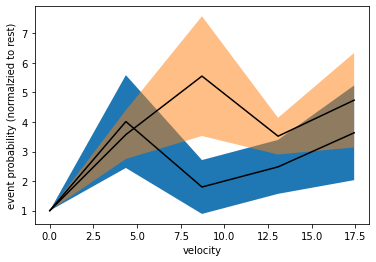

In [28]:
## wt versus ko plot, norm to rest, across sessions 
plt.figure()
plt.plot(list(means_to_plot_wt.index), means_to_plot_wt, color='k')
std_error = std_dev_wt/math.sqrt(len(list(norm_to_rest_wt_no_inf.columns.levels[0])))
plt.fill_between(list(means_to_plot_wt.index), means_to_plot_wt+std_error, 
                 means_to_plot_wt-std_error)
plt.plot(list(means_to_plot_ko.index), means_to_plot_ko, color='k')
std_error_2 = std_dev_ko/math.sqrt(len(list(norm_to_rest_ko_no_inf.columns.levels[0])))
plt.fill_between(list(means_to_plot_ko.index), means_to_plot_ko+std_error_2, 
                 means_to_plot_ko-std_error_2, alpha=0.5)
plt.ylabel('event probability (normalzied to rest)')
plt.xlabel('velocity')
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_probability_by_session_sd25.pdf', transparent=True)
plt.show()

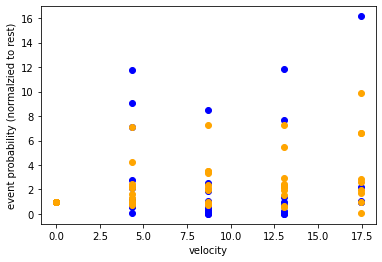

In [22]:
#plot per session, plot versus length 

means_by_session_wt = norm_to_rest_wt_no_inf.mean(axis=1, level=0)
means_by_session_ko = norm_to_rest_ko_no_inf.mean(axis=1, level=0)
v_bins = list(means_by_session_wt.index)

binned_means_dict_wt = {v_bin:means_by_session_wt.loc[v_bin].values for v_bin in v_bins}
binned_means_dict_ko = {v_bin:means_by_session_ko.loc[v_bin].values for v_bin in v_bins}

plt.figure()
for v_bin, session_means in zip(list(binned_means_dict_wt.keys()), list(binned_means_dict_wt.values())):
    plt.scatter([v_bin]*len(session_means), session_means, color='b')
for v_bin, session_means in zip(list(binned_means_dict_ko.keys()), list(binned_means_dict_ko.values())):
    plt.scatter([v_bin]*len(session_means), session_means, color='orange') 
plt.ylabel('event probability (normalzied to rest)')
plt.xlabel('velocity')
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_probability_individual_sessions_25.pdf', transparent=True)
plt.show()    

Text(0.5, 0, 'velocity')

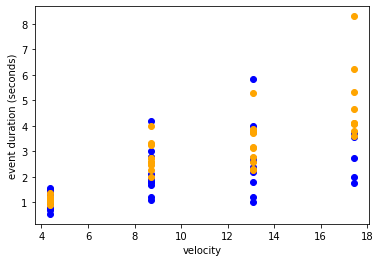

In [23]:
#get average lengths of velocity bins 
event_lengths_all_sessions = {}
for session in list(events_by_session_sorted_by_unique_bin.keys()):
    event_lengths_all_sessions[session] = pd.concat([pd.DataFrame({event:(list(set([idx[0] for idx in list(z_scored_events_by_session[session].loc['z_scored_movement_regions'].loc[event].index)]))[0]-event).total_seconds()
     for event in events_by_session_sorted_by_unique_bin[session][v_bin]}, index=['time (seconds)']) 
               for v_bin in events_by_session_sorted_by_unique_bin[session].keys()], axis=1, keys=events_by_session_sorted_by_unique_bin[session].keys())
event_lengths_all_sessions_df = pd.concat(event_lengths_all_sessions, keys=event_lengths_all_sessions.keys(), axis=1)

mean_lengths_by_session_wt = pd.concat([event_lengths_all_sessions_df[session].mean(axis=1, level=0) for session in list(event_lengths_all_sessions_df.columns.levels[0])
                                    if session in wt_sessions], 
                                       keys=[session for session in list(event_lengths_all_sessions_df.columns.levels[0]) if session in wt_sessions], 
                                       axis=1).swaplevel(i=0, j=1, axis=1)

mean_lengths_by_session_ko = pd.concat([event_lengths_all_sessions_df[session].mean(axis=1, level=0) for session in list(event_lengths_all_sessions_df.columns.levels[0])
                                    if session in ko_sessions], 
                                       keys=[session for session in list(event_lengths_all_sessions_df.columns.levels[0]) if session in ko_sessions], 
                                       axis=1).swaplevel(i=0, j=1, axis=1)

bins_to_test = list(norm_to_rest_wt_no_inf.mean(axis=1).index)[1:]

plt.figure()
for v_bin in bins_to_test: 
    plt.scatter([v_bin]*len(mean_lengths_by_session_wt[bins_to_test][v_bin].values[0]), mean_lengths_by_session_wt[bins_to_test][v_bin].values[0], color='b')
    plt.scatter([v_bin]*len(mean_lengths_by_session_ko[bins_to_test][v_bin].values[0]), mean_lengths_by_session_ko[bins_to_test][v_bin].values[0], color='orange')
    
plt.ylabel('event duration (seconds)')
plt.xlabel('velocity')
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_duration_individual_sessions_sd25.pdf', transparent=True)

Text(0.5, 0, 'velocity')

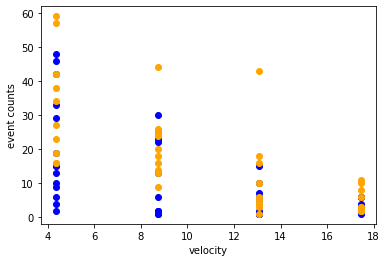

In [24]:
#get event counts in velocity bins 
event_lengths_all_sessions = {}
for session in list(events_by_session_sorted_by_unique_bin.keys()):
    event_lengths_all_sessions[session] = pd.concat([pd.DataFrame({event:(list(set([idx[0] for idx in list(z_scored_events_by_session[session].loc['z_scored_movement_regions'].loc[event].index)]))[0]-event).total_seconds()
     for event in events_by_session_sorted_by_unique_bin[session][v_bin]}, index=['time (seconds)']) 
               for v_bin in events_by_session_sorted_by_unique_bin[session].keys()], axis=1, keys=events_by_session_sorted_by_unique_bin[session].keys())

wt_counts = pd.concat([pd.DataFrame({v_bin: len(events_by_session_sorted_by_unique_bin[session][v_bin]) 
 for v_bin in events_by_session_sorted_by_unique_bin[session].keys()},index=['event counts']) 
           for session in events_by_session_sorted_by_unique_bin.keys() if session in wt_sessions], 
keys=[session for session in list(events_by_session_sorted_by_unique_bin.keys()) if session in wt_sessions], axis=1).swaplevel(i=0, j=1, axis=1)

ko_counts = pd.concat([pd.DataFrame({v_bin: len(events_by_session_sorted_by_unique_bin[session][v_bin]) 
 for v_bin in events_by_session_sorted_by_unique_bin[session].keys()},index=['event counts']) 
           for session in events_by_session_sorted_by_unique_bin.keys() if session in ko_sessions], 
keys=[session for session in list(events_by_session_sorted_by_unique_bin.keys()) if session in ko_sessions], axis=1).swaplevel(i=0, j=1, axis=1)

plt.figure()

bins_to_test = list(norm_to_rest_wt_no_inf.mean(axis=1).index)[1:]

for v_bin in bins_to_test: 
    plt.scatter([v_bin]*len(wt_counts[bins_to_test][v_bin].values[0]), wt_counts[bins_to_test][v_bin].values[0], color='b')
    plt.scatter([v_bin]*len(ko_counts[bins_to_test][v_bin].values[0]), ko_counts[bins_to_test][v_bin].values[0], color='orange')
    
plt.ylabel('event counts')
plt.xlabel('velocity')
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_counts_individual_sessions_sd25.pdf', transparent=True)

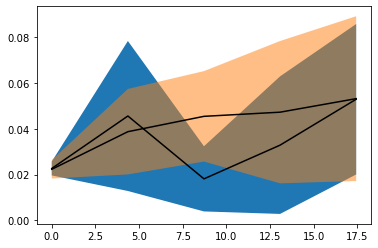

In [25]:
## wt versus ko plot, raw values 
plt.plot(wt_event_by_session_df.mean(axis=1).index, wt_event_by_session_df.mean(axis=1), color='k')
std_error = wt_event_by_session_df.std(axis=1)/math.sqrt(len(wt_event_by_session.keys()))
plt.fill_between(wt_event_by_session_df.mean(axis=1).index, wt_event_by_session_df.mean(axis=1)+std_error, 
                 wt_event_by_session_df.mean(axis=1)-std_error)
plt.plot(ko_event_by_session_df.mean(axis=1), color='k')
std_error_2 = ko_event_by_session_df.std(axis=1)/math.sqrt(len(ko_event_by_session.keys()))
plt.fill_between(ko_event_by_session_df.mean(axis=1).index, ko_event_by_session_df.mean(axis=1)+std_error_2, 
                 ko_event_by_session_df.mean(axis=1)-std_error_2, alpha=0.5)
plt.show()

In [ ]:
##events by session, do this as scatter plot? 
#plot probability for event length 

In [ ]:
for session in wt_event_by_session:
    plt.plot(event_p_by_session[session].mean(axis=1).sort_index())
plt.show()

In [ ]:
for session in ko_event_by_session:
    plt.plot(event_p_by_session[session].mean(axis=1).sort_index())
plt.show()

In [ ]:
#plot lengths of events 

In [ ]:
event_lengths_wt = {}
for session in wt_event_by_session: 
    start_indicies = return_list_of_start_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'])
    end_indicies = return_list_of_stop_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'])
    event_lengths_wt[session] = pd.DataFrame({start_idx: (end_idx-start_idx).total_seconds() for start_idx, end_idx in zip(start_indicies, end_indicies)},
                              index= ['duration']).transpose()
event_lengths_wt_df = pd.concat(event_lengths_wt, keys=wt_event_by_session)

In [ ]:
event_lengths_ko = {}
for session in ko_event_by_session: 
    start_indicies = return_list_of_start_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'])
    end_indicies = return_list_of_stop_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'])
    event_lengths_ko[session] = pd.DataFrame({start_idx: (end_idx-start_idx).total_seconds() for start_idx, end_idx in zip(start_indicies, end_indicies)},
                              index= ['duration']).transpose()
event_lengths_ko_df = pd.concat(event_lengths_ko, keys=ko_event_by_session)

In [ ]:
plt.hist(event_lengths_wt_df['duration'], alpha=0.6)
plt.hist(event_lengths_ko_df['duration'], alpha=0.6)